# Window-Based Detection using KAZE Descriptor Featuring Matching

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl
import scipy.ndimage as ndimage

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *

In [262]:
# Global Variables
curr_wd = os.getcwd()
example_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '004.jpg')
example_full_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '008.jpg')
provided_annot_path = os.path.join(curr_wd, 'cache_anno/', 'classification', 'provided_annots.pkl')

# File path for BOVW
bovw_file_path = os.path.join(curr_wd, 'bovw/')
bovw_file_path_waldo = os.path.join(bovw_file_path, 'waldo/')
bovw_kaze_file_path = os.path.join(bovw_file_path_waldo, 'bovw_kaze_80.pkl')
bovw_sift_file_path = os.path.join(bovw_file_path_waldo, 'bovw_sift_80.pkl')
bovw_brisk_file_path = os.path.join(bovw_file_path_waldo, 'bovw_brisk_80.pkl')

# File path for extra data
extra_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', 'extras')
extra_path_positives = os.path.join(extra_path, 'positives/')
extra_path_negatives = os.path.join(extra_path, 'negatives/')

# Descriptor type to use
desc_type = 'sift'
num_clusters = 80

with open(provided_annot_path, 'rb') as f:
    provided_annots = pickle.load(f)

### Load Dataset

Loads the patches from the `datasets/train/positives` and `datasets/train/extra` as training data for classifier model. The patches are in the type `ndarray`
<br> *Detection classes allowed:* </br>
- **waldo_face_front** </br>
- **waldo_face_side** </br>
- **waldo_body_full** </br>
- **waldo_body_half** </br>
- **wenda_face_front** </br>
- **wenda_body_full** </br>
- **wenda_body_half** </br>
- **wizard_face_front** </br>
- **wizard_body_full** </br>
- **wizard_body_half** </br>
- **other_face_front** </br>
- **other_body_full** </br>
- **other_body_half**</br>

In [123]:
# Load data from all poses for current detection class
detection_class = 'waldo'
face_front = detection_class + '_face_front'
face_side = detection_class + '_face_side'
body_full = detection_class + '_body_full'
body_half = detection_class + '_body_half'

other_face_front = 'other_face_front'
face_side = detection_class + '_face_side'
other_body_full = 'other_body_full'
other_body_half = 'other_body_half'

# Load data for front face
print('Loading data for front face')
detection_type = [face_front]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_ff, valid_instances_ff = list(train_loader), list(valid_loader)

# Load data for side face
print('Loading data for side face')
detection_type = [face_side]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_sf, valid_instances_sf = list(train_loader), list(valid_loader)

# Load data for full body
print('Loading data for full body')
detection_type = [body_full]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_bf, valid_instances_bf = list(train_loader), list(valid_loader)

# Load data for half body
print('Loading data for half body')
detection_type = [body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_bh, valid_instances_bh = list(train_loader), list(valid_loader)

# Load data for all body
print('Loading data for all bodies')
detection_type = [body_full, body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_b, valid_instances_b = list(train_loader), list(valid_loader)

# Load data for all faces
print('Loading data for all faces')
detection_type = [face_front, face_side]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_f, valid_instances_f = list(train_loader), list(valid_loader)

# Load data for all examples
print('Loading all training examples')
detection_type = [face_front, body_full, body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_all, valid_instances_all = list(train_loader), list(valid_loader)

# Load additional training data for negatives
print('Loading extra negative training examples')
detection_type = [other_face_front, other_body_full, other_body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_extra, valid_instances_extra = list(train_loader), list(valid_loader)

Loading data for front face
---num of training instances: 1632
---num of validation instances: 408
Loading data for side face
---num of training instances: 1424
---num of validation instances: 356
Loading data for full body
---num of training instances: 1436
---num of validation instances: 358
Loading data for half body
---num of training instances: 1424
---num of validation instances: 356
Loading data for all bodies
---num of training instances: 2860
---num of validation instances: 714
Loading data for all faces
---num of training instances: 1668
---num of validation instances: 416
Loading all training examples
---num of training instances: 4492
---num of validation instances: 1122
Loading extra negative training examples
---num of training instances: 4876
---num of validation instances: 1218


In [238]:
# Split the data into training examples and labels
train_ff_x, train_ff_y = extract_data(train_instances_ff)
train_sf_x, train_sf_y = extract_data(train_instances_sf)
train_bf_x, train_bf_y = extract_data(train_instances_bf)
train_bh_x, train_bh_y = extract_data(train_instances_bh)
train_f_x, train_f_y = extract_data(train_instances_f)
train_b_x, train_b_y = extract_data(train_instances_b)
train_all_x, train_all_y = extract_data(train_instances_all)
train_extra_x, train_extra_y = extract_data(train_instances_extra)
train_extra_y = np.zeros(len(train_extra_x)).astype('int').tolist()

In [239]:
# Split the data into validation examples and labels
val_ff_x, val_ff_y = extract_data(valid_instances_ff)
val_sf_x, val_sf_y = extract_data(valid_instances_sf)
val_bf_x, val_bf_y = extract_data(valid_instances_bf)
val_bh_x, val_bh_y = extract_data(valid_instances_bh)
val_f_x, val_f_y = extract_data(valid_instances_f)
val_b_x, val_b_y = extract_data(valid_instances_b)
val_all_x, val_all_y = extract_data(valid_instances_all)
val_extra_x, val_extra_y = extract_data(valid_instances_extra)
val_extra_y = np.zeros(len(val_extra_x)).astype('int').tolist()

In [240]:
# Loading extra data
extra_filepaths_positives = load_full_subdir(extra_path_positives)
extra_filepaths_negatives = load_full_subdir(extra_path_negatives)

extra_train_positives = []
for file in extra_filepaths_positives:
    extra_train_positives.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

extra_train_negatives = []
for file in extra_filepaths_negatives:
    extra_train_negatives.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

In [241]:
# Labels for extra data
extra_train_positives_y = np.ones(len(extra_train_positives)).astype('int').tolist()
extra_train_negatives_y = np.zeros(len(extra_train_negatives)).astype('int').tolist()

In [242]:
# Append extra data
train_ff_x = train_ff_x + extra_train_negatives
train_ff_y = train_ff_y + extra_train_negatives_y
# train_ff_x = train_ff_x + train_extra_x
# train_ff_y = train_ff_y + train_extra_y
val_ff_x = val_ff_x + val_extra_x
val_ff_y = val_ff_y + val_extra_y

In [243]:
train_f_x = train_f_x + extra_train_negatives
train_f_y = train_f_y + extra_train_negatives_y
# train_f_x = train_f_x + train_extra_x
# train_f_y = train_f_y + train_extra_y
val_f_x = val_f_x + val_extra_x
val_f_y = val_f_y + val_extra_y

train_all_x = train_all_x + extra_train_negatives
train_all_y = train_all_y + extra_train_negatives_y
# train_all_x = train_all_x + train_extra_x
# train_all_y = train_all_y + train_extra_y
val_all_x = val_all_x + val_extra_x
val_all_y = val_all_y + val_extra_y

# train_x = train_extra_x + extra_train_positives
train_x = train_x + extra_train_negatives
# train_y = train_extra_y + extra_train_positives_y
train_y = train_y + extra_train_negatives_y

In [26]:
# Extract feature descriptors from entire training set
# Compute cluster centers to be used as bag of words
if os.path.isfile(bovw_kaze_file_path):
    with open(bovw_kaze_file_path, 'rb') as f:
        bag_of_words_kaze = pickle.load(f)
else:
    print('Clustering KAZE Descriptors')
    train_features_kaze = extract_features(train_all_x, desc_type='kaze')
    bag_of_words_kaze = cluster_features(train_features_kaze, num_clusters=num_clusters)
    with open(bovw_kaze_file_path, 'wb') as f:
        pickle.dump(bag_of_words_kaze, f)
    print('Number of KAZE descriptors:', len(train_features_kaze))

if os.path.isfile(bovw_sift_file_path):
    with open(bovw_sift_file_path, 'rb') as f:
        bag_of_words_sift = pickle.load(f)
else:
    print('Clustering SIFT Descriptors')
    train_features_sift = extract_features(train_all_x, desc_type='sift')
    bag_of_words_sift = cluster_features(train_features_sift, num_clusters=num_clusters)
    with open(bovw_sift_file_path, 'wb') as f:
        pickle.dump(bag_of_words_sift, f)
    print('Number of SIFT descriptors:', len(train_features_sift))

if os.path.isfile(bovw_brisk_file_path):
    with open(bovw_brisk_file_path, 'rb') as f:
        bag_of_words_brisk = pickle.load(f)
else:
    print('Clustering BRISK Descriptors')
    train_features_brisk = extract_features(train_all_x, desc_type='brisk')
    bag_of_words_brisk = cluster_features(train_features_brisk, num_clusters=num_clusters)
    with open(bovw_brisk_file_path, 'wb') as f:
        pickle.dump(bag_of_words_brisk, f)
    print('Number of BRISK descriptors:', len(train_features_brisk))

### Train Classifier

After extracting the Bag Of Words from the training patches, we then train our classifer on the histogram vector features from training data patches, and test it on our validation patches

#### Classifier for Front Face

In [244]:
# Generate classifiers for front face
svm_linear_ff, svm_rbf_ff, gbc_ff, rf_ff = generate_models(train_ff_x, train_ff_y, val_ff_x, val_ff_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.519
Recall: 0.753
F1 Score: 0.615


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.554
Recall: 0.767
F1 Score: 0.644
Performance of RandomForestClassifier on validation set:
Precision: 0.671
Recall: 0.753
F1 Score: 0.710


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for Side Face

In [245]:
# Generate classifiers for side face
svm_linear_sf, svm_rbf_sf, gbc_sf, rf_sf = generate_models(train_sf_x, train_sf_y, val_sf_x, val_sf_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.222
F1 Score: 0.364
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.111
F1 Score: 0.200


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for Full Body

In [246]:
# Generate classifiers for full body
svm_linear_bf, svm_rbf_bf, gbc_bf, rf_bf = generate_models(train_bf_x, train_bf_y, val_bf_x, val_bf_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.583
F1 Score: 0.737
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.417
F1 Score: 0.588


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for Half Body

In [247]:
# Generate classifiers for half body
svm_linear_bh, svm_rbf_bh, gbc_bh, rf_bh = generate_models(train_bh_x, train_bh_y, val_bh_x, val_bh_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.222
F1 Score: 0.364
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.111
F1 Score: 0.200


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for All Faces

In [248]:
# Generate classifiers for all faces
svm_linear_f, svm_rbf_f, gbc_f, rf_f = generate_models(train_f_x, train_f_y, val_f_x, val_f_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.441
Recall: 0.824
F1 Score: 0.574


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.456
Recall: 0.838
F1 Score: 0.591
Performance of RandomForestClassifier on validation set:
Precision: 0.515
Recall: 0.765
F1 Score: 0.615


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for all body poses

In [249]:
# Generate classifiers for all body poses
svm_linear_b, svm_rbf_b, gbc_b, rf_b = generate_models(train_b_x, train_b_y, val_b_x, val_b_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.833
Recall: 0.500
F1 Score: 0.625
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.400
F1 Score: 0.571


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for entire training data

In [250]:
# Generate classifiers for front face
svm_linear_all, svm_rbf_all, gbc_all, rf_all = generate_models(train_all_x, train_all_y, val_all_x, val_all_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.829
Recall: 0.768
F1 Score: 0.797


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.740
Recall: 0.695
F1 Score: 0.717


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Performance of RandomForestClassifier on validation set:
Precision: 0.860
Recall: 0.524
F1 Score: 0.652


#### Classifier for extra data

In [251]:
# Generate classifiers for extra data
svm_linear_extra, svm_rbf_extra, gbc_extra, rf_extra = generate_models(train_x, train_y, val_all_x, val_all_y, bag_of_words_sift, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Performance of RandomForestClassifier on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Sliding Window Scoring

We now use our trained classifer to score each window, and threshold windows that have scores beyond a certain benchmark

In [252]:
# Perform stacking of models - Feel free to select multiple models from those trained above
stacked_classifiers = [
    svm_linear_ff, gbc_ff, # Front Face Classifiers
#     gbc_sf, rf_sf, # Side Face Classifiers
#     gbc_bf, rf_bf, # Full Body Classifiers
#     gbc_bh, rf_bh, # Half Body Classifiers
#     svm_linear_f, gbc_f, # All Face Classifiers
    gbc_b, # All Body Classifiers
    svm_linear_all, gbc_all # All Classifier
#     rf_extra # To counter false positives
]

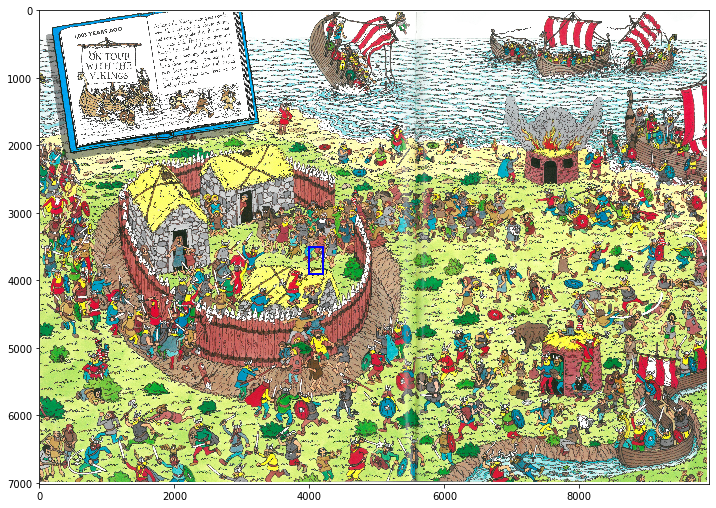

In [263]:
# Visualise window on training image
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)

window_size = (200, 400)
step_size = 500

example_full = plt.imread(example_full_path)
# example_full = cv2.GaussianBlur(example_full, (3, 3), cv2.BORDER_DEFAULT)
ax.imshow(example_full)

rect = patches.Rectangle((4000, 3500), window_size[0], window_size[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

plt.show()

In [264]:
# Perform detection
detections = detect(example_full, bag_of_words_sift, stacked_classifiers, window_scale=5, desc_type=desc_type)
print('Number of Bounding Boxes: ', len(detections))

Current Window Size:  310 219
Current step size:  109
Current Window Size:  620 438
Current step size:  218
Current Window Size:  1240 876
Current step size:  872
Number of Bounding Boxes:  20


In [265]:
ground_truth = [0] * 4
for box in provided_annots['008.jpg']:
    coord, label = box
    if label[0] == 'waldo':
        ground_truth = coord

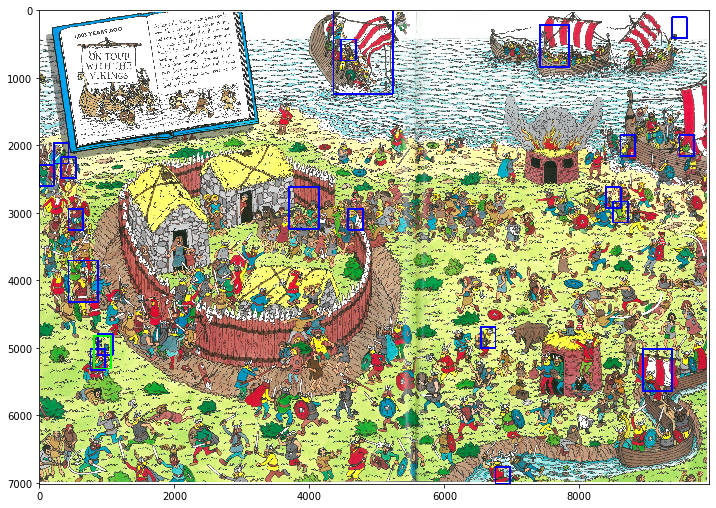

In [266]:
# Visualise detections
clone = example_full.copy()
for (x1, y1, x2, y2, score) in detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)